# 📚 Discovering Book Micro-Genres with Unsupervised Learning

The goal is to identify hidden micro-genres by clustering books based on the words in their descriptions. 
Using unsupervised learning and KMeans clustering, we group similar books without relying on labeled genres. 
Descriptions are transformed into numerical features using TF-IDF vectorization.


## 🔍 Step 1: Define the Problem

Can we find clusters of similar books based on the presence of common words in their descriptions?

This task is suitable for **unsupervised learning** because we don't have labeled genres.


In [1]:
# Necessary libraries

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from datasets import load_dataset

!pip install langdetect
from langdetect import detect, LangDetectException

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 25.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=1317894c66a936c4e07a1d621abdbe658435bd4f8e1162c0ddc338bd4563abbf
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


## 📂 Step 2: Load and Explore the Data

We use a book dataset with fields like title, author, and summary.
Only the `title` and `summary` columns are used for clustering.

Below is a sample of the data and basic info:


In [2]:
dataset = load_dataset('BrightData/Goodreads-Books')

README.md: 0.00B [00:00, ?B/s]

Goodreads-Books.csv:   0%|          | 0.00/8.29G [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Loading dataset shards:   0%|          | 0/17 [00:00<?, ?it/s]

## <a id="id5">Exploratory Data Analysis (EDA)</a>

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['url', 'id', 'name', 'author', 'star_rating', 'num_ratings', 'num_reviews', 'summary', 'genres', 'first_published', 'about_author', 'community_reviews', 'kindle_price'],
        num_rows: 6389859
    })
})

In [4]:
dataset = dataset['train']
dataset = dataset.select(range(10000))
Data= dataset.select_columns(["name", "summary"]).to_pandas()
Data = Data.rename(columns={"name": "title", "summary": "description"})

In [5]:
Data.head()

,title,description
0,"Horror Film Directors, 1931-1990",An exhaustive study of the major directors of ...
1,"Australian Urban Planning: New Challenges, New...","Designed for use by academics, students, plann..."
2,Morgen ohne gestern: Roman,Christine Hoffmann wacht eines Morgens im Kran...
3,Zen and the Art of Recording,"In this book, the third in the Zen and the Art..."
4,The Big Book Of Codewords,500 codeword puzzles in one great book!


In [6]:
print(Data.isna().sum())

title            0
description    993
dtype: int64


In [7]:
Data = Data.dropna()

In [8]:
def remove_non_english(Data, col):
    def is_english(text):
        try:
            return detect(str(text)) == 'en'
        except LangDetectException:
            return False 
    return Data[Data[col].apply(is_english)]


In [9]:
Data = remove_non_english(Data, 'description')

In [10]:
Data.shape

(7346, 2)

### 🧹 Text Cleaning and Preprocessing

We apply the following steps to prepare the text:
- Convert to lowercase
- Remove stopwords (e.g., "a", "the", "and")
- Lemmatize words (reduce to base form)

This ensures the descriptions are clean and consistent for vectorization.


In [11]:
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
stopWords = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

In [13]:
def preprocessText(txt):
    txt = txt.lower()
    token_txt = word_tokenize(txt)
    

    filtered_tokens = [
        word for word in token_txt 
        if word not in stopWords 
    ]
    
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos='v') for token in filtered_tokens]
    
    return ' '.join(lemmatized_tokens)


In [14]:
Data['description'].apply(preprocessText)

0       exhaustive study major directors horror film p...
1       design use academics , students , plan profess...
3       book , third zen art series , mixerman distill...
4                    500 codeword puzzle one great book !
5       antique apples kilcherman ’ christmas cove far...
                              ...                        
9992    “ circle fifths ” intend help beginner early i...
9994    * * * read free kindle unlimited * * * special...
9995    help teach intermediate japanese well-known ch...
9997    collection twelve stories , barry lopez—the na...
9999    kevin o'rourke 's debut collection explore mea...
Name: description, Length: 7346, dtype: object

### 🔢 Text Vectorization (TF-IDF)

We use **TF-IDF vectorization** to convert the cleaned book descriptions into numerical features.
This allows the clustering algorithm to compare books based on word importance.


In [15]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(Data['description'])

## 🔗 Step 3: Apply KMeans Clustering

We apply the KMeans algorithm to group books into clusters based on their TF-IDF vectors.

Each cluster represents a group of books with similar themes or topics — what we call **micro-genres**.


In [16]:
scores = []
k_range = range(2, 25)

best_k = 0
best_score = -1 

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    
    scores.append(score)
    
    if score > best_score:
        best_score = score
        best_k = k


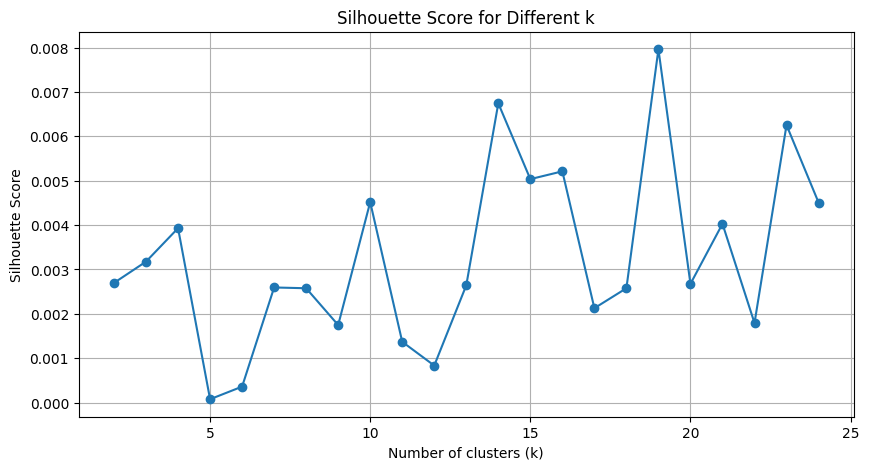

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(list(k_range), scores, marker='o')  
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different k')
plt.grid(True)
plt.show()


In [18]:
model = KMeans(n_clusters=best_k, n_init=10, random_state=42)
Data["genre"] = model.fit_predict(X)

In [19]:
Data.head(20)

,title,description,genre
0,"Horror Film Directors, 1931-1990",An exhaustive study of the major directors of ...,9
1,"Australian Urban Planning: New Challenges, New...","Designed for use by academics, students, plann...",9
3,Zen and the Art of Recording,"In this book, the third in the Zen and the Art...",9
4,The Big Book Of Codewords,500 codeword puzzles in one great book!,7
5,Antique Apples from Kilcherman's Christmas Cov...,Antique Apples from Kilcherman’s Christmas Cov...,5
6,It's A Wonderful Death: A Fortannis Novel,A brave knight breaks her vows to fight agains...,12
8,Oman Under Qaboos,"This is an examination of the political, econo...",9
9,Quilts From Lavender Hill Farm: 12 Projects In...,Bring a Touch of the Country Into Your Home In...,13
14,"Il Gigante: Michelangelo, Florence, and the Da...","At the turn of the 16th century, Italy was a t...",5
16,Ok Cupid Dating Success: Attract & Seduce Girl...,Over half of new relationships start online th...,8


## 📊 Step 4: Evaluate Clustering

We use the **Silhouette Score** to evaluate the quality of the clustering.

In [20]:
score = best_score
print(f"Silhouette Score: {score}")

Silhouette Score: 0.007962643028240826


### 💾 Save Results to CSV

We save the clustered data to a CSV file for further exploration, analysis, or use in other systems.


In [21]:
Data.to_csv("Book's_genre.csv", index=False)

### ✅ Conclusion

- We explored whether book descriptions can reveal hidden micro-genres using clustering.
- Text preprocessing and TF-IDF allowed us to convert descriptions into numerical features.
- KMeans grouped the books, but evaluation shows clustering can be improved.
- Future work: Try more clusters, better text cleaning, or advanced models like LDA or embeddings.
